## Import Libraries

In [82]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [83]:
df = pd.read_csv("./Higher player.csv")

In [84]:
df.shape

(4840, 19)

In [85]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [86]:
df.drop(columns='Unnamed: 0' , inplace = True)
# df.drop(columns='name' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [87]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [88]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [89]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [90]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [91]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2017
Cheap_Price    1603
High_Price     1220
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [56]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [58]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [59]:
df.shape

(4840, 352)

In [60]:
encoder = LabelEncoder()
df['position'] = encoder.fit_transform(df['position'])  

#### 3. Feature selection

In [61]:
# sns.heatmap(df.corr(), annot=True);

In [62]:
correlation = df.corr()
correlation['position'].sort_values(ascending=False)

position          1.000000
yellow cards      0.135356
goals conceded    0.133292
clean sheets      0.129880
minutes played    0.064833
                    ...   
award            -0.044401
highest_value    -0.060210
height           -0.077749
assists          -0.192353
goals            -0.513394
Name: position, Length: 352, dtype: float64

In [63]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['position']) > threshold]['position'].index
selected_features

Index(['position', 'goals', 'assists', 'yellow cards', 'goals conceded',
       'clean sheets'],
      dtype='object')

In [64]:
df = df[selected_features]

#### 4. Prepare train and test data

In [65]:
# Prepare data
X = df.drop(['position'], axis=1)
y = df['position']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
X.shape

(4840, 5)

## Buliding the Model

In [67]:
model = LogisticRegression()

## Train the Model

In [68]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [69]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [70]:
model.coef_

array([[ 1.44874631, -0.89530643, -0.13961074,  0.06752845,  0.06877757],
       [ 3.07645917,  0.09611108,  0.07417862, -0.03909997, -0.03724324],
       [ 1.59158772,  0.85268249, -0.024663  , -0.05355693, -0.05008874],
       [ 1.32117407,  0.87279295, -0.03139961, -0.06241772, -0.05780117],
       [ 1.97878687,  0.98238478, -0.19322498, -0.00792641, -0.00734048],
       [-0.50129039, -0.28730535, -0.45460151,  0.01984951,  0.02570556],
       [-2.10658266, -3.17536783,  0.19722526, -0.66570691, -0.51616755],
       [-2.95199787,  0.4644709 ,  0.03101668, -0.36738138, -0.29250817],
       [-3.38239934,  0.20699419,  0.17879612, -0.41341429, -0.32744405],
       [-0.36594433, -0.5346693 , -0.44825597,  2.12631824,  1.69377967],
       [ 0.80466404, -0.86093684, -0.53581738,  0.04031681,  0.0444537 ],
       [ 1.3165124 ,  0.85976046,  0.12785306, -0.06070723, -0.05649418],
       [-0.21603408,  0.31439422,  0.48099212, -0.16987844, -0.14497323],
       [-1.75313974, -0.6341205 ,  0.6

In [71]:
print(model.intercept_) 

[-3.27812752  0.89931042  1.46547574  1.71331463 -1.33383922 -3.22130777
  0.83887447  1.40328617  1.21790921 -2.60564246 -3.24941123  1.7582947
  2.80263465  1.71825109 -0.16949788  0.04047502]


## Evaluating the Model 

In [72]:
# our benchmark model
base_model = round(df['position'].value_counts()[1]/df.shape[0]*100, 2)
base_model

12.07

1. Accuracy

In [73]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy' ,accuracy_train*100)

Test Accuracy 48.96694214876033
Train Accuracy 48.992768595041326


2. Precision

In [74]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print("Test Precision:" ,precision_test*100)

y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Precision:' ,precision_train*100)

Test Precision: 31.158772632003156
Train Precision: 25.143459620281472


3. Recall

In [75]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test Recall:" , recall_test*100)

y_pred_train = model.predict(X_train_scaled)
recall_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,recall_train*100)

Test Recall: 30.48191754282324
Train Recall: 25.143459620281472


4. F1 Score

In [76]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print("Test F1 Score:" , f1_test*100)

y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,f1_train*100)

Test F1 Score: 28.899424478133867
Train Recall: 23.61141465621132


#### Predictions vs. Real Values

In [77]:
predictions = model.predict(X_test_scaled)

In [78]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

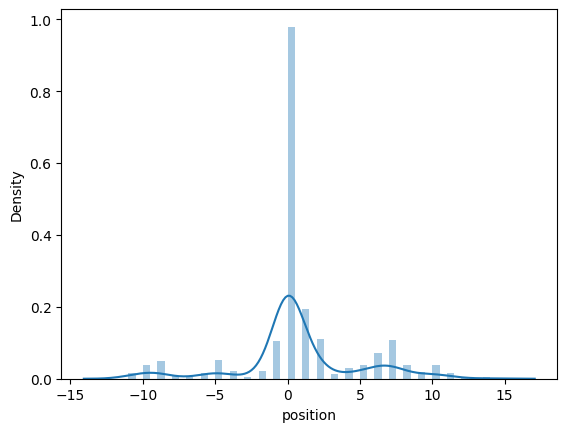

In [79]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [80]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[114,   4,   4,   0,   3,   0,   0,   0,   5,   8,   0,   0,   0],
       [ 27,   3,   7,   0,   1,   1,   0,   0,   5,  13,   0,   0,   0],
       [ 21,   5,  11,   0,   1,   1,   0,   0,   3,  19,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 168,   2,   6,   0,   0,   7,   2,   0,   0],
       [  1,   0,   2,   0,  28,  14,  15,   0,   0,  17,   1,   0,   0],
       [  0,   0,   3,   0,  31,  13,  17,   0,   1,   9,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  85,   0,   0,   0,   0,   0],
       [ 18,   6,  15,   0,   1,   2,   1,   0,   6,  18,   1,   0,   0],
       [  8,   0,   3,   0,  29,  10,  11,   0,   3,  47,   5,   0,   0],
       [  1,   0,   0,   0,  49,   4,   5,   0,   0,  18,   9,   0,   0],
       [  0,   0,   0,   0,   2,   2,   0,   0,   1,   1,   0,   0,   0],
       [  2,   0,   1,   0,   0,   1,   1,   0,   0,   2,   1,   0,   0]],
      dtype=int64)